In [1]:
# coding=utf-8

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import pickle
import time
import os

scale_max = np.array([50, 53.55, 135.05, 4000, 6, 366, 31, 12, 50, 50, 50, 50, 50])  # 各要素的最大值
scale_min = np.array([-50, 3.86, 73.66, -10, 0, 1, 1, 1, 0, 0, -50, -50, -50])  # 各要素的最小值
scale_ = scale_max - scale_min


def current_time():
    ct = datetime.datetime.now().strftime('%Y:%m:%d:%H:%M:%S')
    return ct

features = [
    # 'PRS_Avg',            # 平均气压
    'TEM_Avg',            # 平均气温
    # 'WIN_S_2mi_Avg',      # 平均风速
    'Lat',                # 纬度
    'Lon',                # 经度
    'Alti',               # 海拔
    'dow',                # 星期
    'doy',                # 一年的第几天
    'day',                # 一月的第几天
    'month',              # 月份
    't_w24',              # 昨天的风速
    't_w48',              # 前天的风速
    # 'tdif2',              # 今天与昨天的风速差
    't_t24',              # 昨天的气温
    't_t48',              # 前天的气温
    'tdif3'               # 今天与昨天的气温差
]

In [2]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [11]:
def get_prev_days(x, n_days):
    try:
        lo = df[df.Data_Time == x - n_days*pday].PRE_Time_2020.values[0]
    except:
        lo = df[df.Data_Time == x].PRE_Time_2020.values[0]
    return lo


def get_prev_days_1(x, n_days):
    try:
        lo = df[df.Data_Time == x - n_days*pday].WIN_S_2mi_Avg.values[0]
    except:
        lo = df[df.Data_Time == x].WIN_S_2mi_Avg.values[0]
    return lo


def get_prev_days_2(x, n_days):
    try:
        lo = df[df.Data_Time == x - n_days*pday].TEM_Avg.values[0]
    except:
        lo = df[df.Data_Time == x].TEM_Avg.values[0]
    return lo

In [13]:
def preprocess(df):
    df['Data_Time'] = df['Data_Time'].astype(unicode)
    df['Data_Time'] = pd.to_datetime(df['Data_Time'])

    df['dow'] = df.Data_Time.apply(lambda x: x.dayofweek)     # 周几
    df['doy'] = df.Data_Time.apply(lambda x: x.dayofyear)     # 一年的第几天
    df['day'] = df.Data_Time.apply(lambda x: x.day)           # 一个月的第几天
    df['month'] = df.Data_Time.apply(lambda x: x.month)       # 第几个月

    df['t_m24'] = df.Data_Time.apply(get_prev_days, args=(1,))    # 昨天的降雨量
    df['t_m48'] = df.Data_Time.apply(get_prev_days, args=(2,))    # 前天的降雨量
    df['t_m72'] = df.Data_Time.apply(get_prev_days, args=(3,))    # 大前天的降雨量
    # df['tdif'] = df['PRE_Time_2020'] - df['t_m24']

    df['t_w24'] = df.Data_Time.apply(get_prev_days_1, args=(1,))    # 昨天的风速
    df['t_w48'] = df.Data_Time.apply(get_prev_days_1, args=(2,))    # 前天的风速
    df['tdif2'] = df['WIN_S_2mi_Avg'] - df['t_w24']                 # 今天的风速与昨天的风速差

    df['t_t24'] = df.Data_Time.apply(get_prev_days, args=(1,))    # 昨天的气温
    df['t_t48'] = df.Data_Time.apply(get_prev_days, args=(2,))    # 前天的气温
    df['tdif3'] = df['TEM_Avg'] - df['t_t24']                     # 今天的气温与昨天的气温差
    df['Lat'] = 23.55
    df['Lon'] = 110.38
    df['Alti'] = 3
    return df

In [14]:
df = pd.read_csv("/home/sinoeco/hdd/pzw/pingnan/pingnan_59255_20180101.csv")
df = preprocess(df)

x_test = df[features].values
print x_test.shape
print np.max(x_test, axis=0)
print np.min(x_test, axis=0)

(184, 13)
[ 31.    23.55 110.38   3.     6.   184.    31.     7.     2.     2.
 110.   110.    31.  ]
[  5.    23.55 110.38   3.     0.     1.     1.     1.     0.     0.
   0.     0.   -85.  ]


In [15]:
x_test

array([[ 16.  ,  23.55, 110.38, ...,   0.  ,   0.  ,  16.  ],
       [ 17.  ,  23.55, 110.38, ...,   0.  ,   0.  ,  17.  ],
       [ 19.  ,  23.55, 110.38, ...,   0.  ,   0.  ,  19.  ],
       ...,
       [ 30.  ,  23.55, 110.38, ...,  12.  ,  12.  ,  18.  ],
       [ 30.  ,  23.55, 110.38, ...,   6.  ,   6.  ,  24.  ],
       [ 30.  ,  23.55, 110.38, ...,   7.  ,   7.  ,  23.  ]])

In [16]:
x_test = np.array([np.clip(xi, a_min=scale_min, a_max=scale_max) for xi in x_test])  # 异常值处理

In [19]:
print x_test.shape

(184, 13)


In [17]:
def get_onehot(y):
    y_1 = list()
    for i in y:
        if i < 10.:
            y_1.append(0)
        elif i < 25.:
            y_1.append(1)
        elif i < 50.:
            y_1.append(2)
        else:
            y_1.append(3)
    return np.array(y_1)

In [18]:
y_test = df['PRE_Time_2020'].values
print y_test[:10]
y_test = get_onehot(y_test)
print y_test[:10]

[ 0  0  0  0  0  6 70 20  9  0]
[0 0 0 0 0 0 3 1 0 0]


In [20]:
with open("/home/sinoeco/hdd/pzw/wp_01/model/model01.pickle", "rb") as fr:
    model01 = pickle.load(fr)

In [21]:
y_pred = model01.predict_proba(x_test)
y_pred[:10]

array([[0.76971674, 0.15184939, 0.05899313, 0.01944072],
       [0.7515814 , 0.16261284, 0.06324088, 0.02256494],
       [0.7534943 , 0.14446025, 0.06997598, 0.03206948],
       [0.75693434, 0.13811277, 0.06955019, 0.03540273],
       [0.7933266 , 0.15372199, 0.04246464, 0.01048676],
       [0.3868072 , 0.4696298 , 0.12319139, 0.02037163],
       [0.29117745, 0.43309337, 0.19275472, 0.08297451],
       [0.3219208 , 0.4873903 , 0.15467617, 0.03601268],
       [0.3597149 , 0.4915123 , 0.13123883, 0.01753397],
       [0.8002801 , 0.14628519, 0.04283683, 0.01059789]], dtype=float32)

In [22]:
acc = accuracy_score(y_test, np.argmax(y_pred, axis=1))
print "LogisticReg", "accuracy is %.2f%%" % (acc * 100.)

LogisticReg accuracy is 79.35%


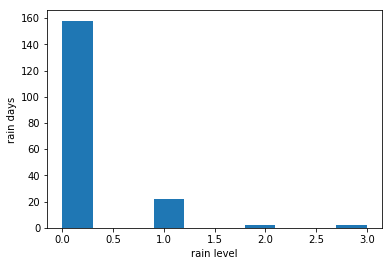

In [23]:
%matplotlib inline 

plt.hist(y_test)
plt.xlabel('rain level')
plt.ylabel('rain days')
plt.show()

In [24]:
print y_test[10:20], '\n'*2, y_pred[10:20]

[0 0 0 0 0 0 0 0 0 0] 

[[0.8002801  0.14628519 0.04283683 0.01059789]
 [0.8002801  0.14628519 0.04283683 0.01059789]
 [0.7974369  0.14582278 0.04521108 0.01152924]
 [0.79050654 0.14974207 0.04642622 0.01332517]
 [0.7931963  0.14247334 0.04800623 0.01632408]
 [0.7616697  0.15137272 0.06408975 0.02286782]
 [0.75659    0.14543068 0.07026347 0.02771584]
 [0.7534943  0.14446025 0.06997598 0.03206948]
 [0.75693434 0.13811277 0.06955019 0.03540273]
 [0.7534943  0.14446025 0.06997598 0.03206948]]


In [25]:
rain_ind = [ind for ind, key in enumerate(y_test) if key != 0]
print rain_ind

[6, 7, 52, 65, 87, 104, 109, 112, 115, 119, 128, 129, 136, 146, 148, 151, 153, 154, 155, 162, 163, 171, 172, 176, 179, 181]


In [26]:
print y_test[rain_ind], '\n'*2, y_pred[rain_ind]

[3 1 1 2 2 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 

[[0.29117745 0.43309337 0.19275472 0.08297451]
 [0.3219208  0.4873903  0.15467617 0.03601268]
 [0.27652124 0.5371039  0.16142832 0.02494658]
 [0.2607794  0.44187638 0.23422147 0.0631227 ]
 [0.23349977 0.3339068  0.27733237 0.15526104]
 [0.18631761 0.46380934 0.25079843 0.09907468]
 [0.200211   0.40994024 0.26120698 0.12864177]
 [0.18252103 0.36816347 0.25931177 0.19000374]
 [0.18469688 0.43434772 0.2563728  0.12458257]
 [0.1957024  0.41446936 0.26409286 0.1257354 ]
 [0.17156735 0.41065013 0.2697019  0.14808065]
 [0.16913885 0.40483746 0.2724493  0.15357436]
 [0.5969181  0.2564405  0.10758143 0.03905995]
 [0.7549419  0.14148723 0.07160292 0.03196797]
 [0.3619587  0.40217778 0.18025011 0.05561336]
 [0.35053533 0.4088683  0.18053076 0.06006557]
 [0.34457815 0.40707242 0.18648937 0.06186004]
 [0.7583554  0.14142214 0.06887175 0.0313507 ]
 [0.17938854 0.46356165 0.25203174 0.10501807]
 [0.18058825 0.46710345 0.25240594 0.09990241]
 [0.

In [35]:
print df.Data_Time[6]

2018-01-07 00:00:00


In [42]:
for rain_i in rain_ind:
    max_proba = np.argmax(y_pred[rain_i])
    print "广西省平南县", df.Data_Time[rain_i], "的全天降雨概率是%.2f%%"% (y_pred[rain_i][max_proba]*100)

广西省平南县 2018-01-07 00:00:00 的全天降雨概率是43.31%
广西省平南县 2018-01-08 00:00:00 的全天降雨概率是48.74%
广西省平南县 2018-02-22 00:00:00 的全天降雨概率是53.71%
广西省平南县 2018-03-07 00:00:00 的全天降雨概率是44.19%
广西省平南县 2018-03-29 00:00:00 的全天降雨概率是33.39%
广西省平南县 2018-04-15 00:00:00 的全天降雨概率是46.38%
广西省平南县 2018-04-20 00:00:00 的全天降雨概率是40.99%
广西省平南县 2018-04-23 00:00:00 的全天降雨概率是36.82%
广西省平南县 2018-04-26 00:00:00 的全天降雨概率是43.43%
广西省平南县 2018-04-30 00:00:00 的全天降雨概率是41.45%
广西省平南县 2018-05-09 00:00:00 的全天降雨概率是41.07%
广西省平南县 2018-05-10 00:00:00 的全天降雨概率是40.48%
广西省平南县 2018-05-17 00:00:00 的全天降雨概率是59.69%
广西省平南县 2018-05-27 00:00:00 的全天降雨概率是75.49%
广西省平南县 2018-05-29 00:00:00 的全天降雨概率是40.22%
广西省平南县 2018-06-01 00:00:00 的全天降雨概率是40.89%
广西省平南县 2018-06-03 00:00:00 的全天降雨概率是40.71%
广西省平南县 2018-06-04 00:00:00 的全天降雨概率是75.84%
广西省平南县 2018-06-05 00:00:00 的全天降雨概率是46.36%
广西省平南县 2018-06-12 00:00:00 的全天降雨概率是46.71%
广西省平南县 2018-06-13 00:00:00 的全天降雨概率是42.69%
广西省平南县 2018-06-21 00:00:00 的全天降雨概率是59.23%
广西省平南县 2018-06-22 00:00:00 的全天降雨概率是41.17%
广西省平南县 2018-06-26 00:00:00 的全天降雨概率

In [45]:
def get_onehot_2(y):
    y_1 = list()
    for i in y:
        if i < 10.:
            y_1.append(0)
#         elif i < 25.:
#             y_1.append(1)
#         elif i < 50.:
#             y_1.append(2)
        else:
            y_1.append(1)
    return np.array(y_1)

In [43]:
with open("/home/sinoeco/hdd/pzw/wp_01/model_cl2/model01.pickle", "rb") as fr:
    model201 = pickle.load(fr)
y_pred2 = model201.predict_proba(x_test)


In [44]:
print y_test[rain_ind], '\n'*2, y_pred2[rain_ind]

[3 1 1 2 2 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 

[[0.3452894  0.6547106 ]
 [0.32934302 0.670657  ]
 [0.2525012  0.7474988 ]
 [0.24773985 0.75226015]
 [0.22053403 0.779466  ]
 [0.17957872 0.8204213 ]
 [0.19202697 0.807973  ]
 [0.20305097 0.796949  ]
 [0.17991441 0.8200856 ]
 [0.18281907 0.81718093]
 [0.15987927 0.84012073]
 [0.15987927 0.84012073]
 [0.63920724 0.3607928 ]
 [0.790758   0.20924197]
 [0.36346447 0.6365355 ]
 [0.33907676 0.66092324]
 [0.32188666 0.67811334]
 [0.78046834 0.21953164]
 [0.16950941 0.8304906 ]
 [0.1718933  0.8281067 ]
 [0.13659662 0.8634034 ]
 [0.58111423 0.41888577]
 [0.3080902  0.6919098 ]
 [0.14883542 0.8511646 ]
 [0.7601826  0.2398174 ]
 [0.7735797  0.22642025]]


In [48]:
y_test2 = df['PRE_Time_2020'].values
print y_test2[:10]
y_test2 = get_onehot_2(y_test2)
print y_test2[:10]

[ 0  0  0  0  0  6 70 20  9  0]
[0 0 0 0 0 0 1 1 0 0]


In [49]:
acc = accuracy_score(y_test2, np.argmax(y_pred2, axis=1))
print "LogisticReg", "accuracy is %.2f%%" % (acc * 100.)

LogisticReg accuracy is 66.85%
